TensorFlow Version: 2.18.0
Using dataset path: C:\Users\91947\Desktop\dap and iot\test\result\pro

--- Loading Training and Validation Data ---
Found 8211 files belonging to 3 classes.
Using 6569 files for training.
Found 8211 files belonging to 3 classes.
Using 1642 files for validation.
Class names found: ['Normal', 'Osteopenia', 'Osteoporosis']

--- Applying Preprocessing ---

--- Optimizing Datasets (Caching & Prefetching) ---

--- Building ResNet50 Model ---

--- Compiling Model ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │           6,147 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,593,859 (90.00 MB)

 Trainable params: 6,147 (24.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)


--- Setting up Callbacks ---

--- Starting Model Training ---
Epoch 1/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6113 - loss: 0.9903
Epoch 1: val_accuracy improved from -inf to 0.75091, saving model to models\best_osteoporosis_resnet50.keras
206/206 ━━━━━━━━━━━━━━━━━━━━ 372s 2s/step - accuracy: 0.6116 - loss: 0.9893 - val_accuracy: 0.7509 - val_loss: 0.5668
Epoch 2/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7132 - loss: 0.6280
Epoch 2: val_accuracy improved from 0.75091 to 0.75883, saving model to models\best_osteoporosis_resnet50.keras
206/206 ━━━━━━━━━━━━━━━━━━━━ 356s 2s/step - accuracy: 0.7132 - loss: 0.6280 - val_accuracy: 0.7588 - val_loss: 0.5457
Epoch 3/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7441 - loss: 0.5819
Epoch 3: val_accuracy improved from 0.75883 to 0.76005, saving model to models\best_osteoporosis_resnet50.keras
206/206 ━━━━━━━━━━━━━━━━━━━━ 352s 2s/step - accuracy: 0.7440 - loss: 0.5818 - val_accuracy: 0.7600 - val_loss: 0.

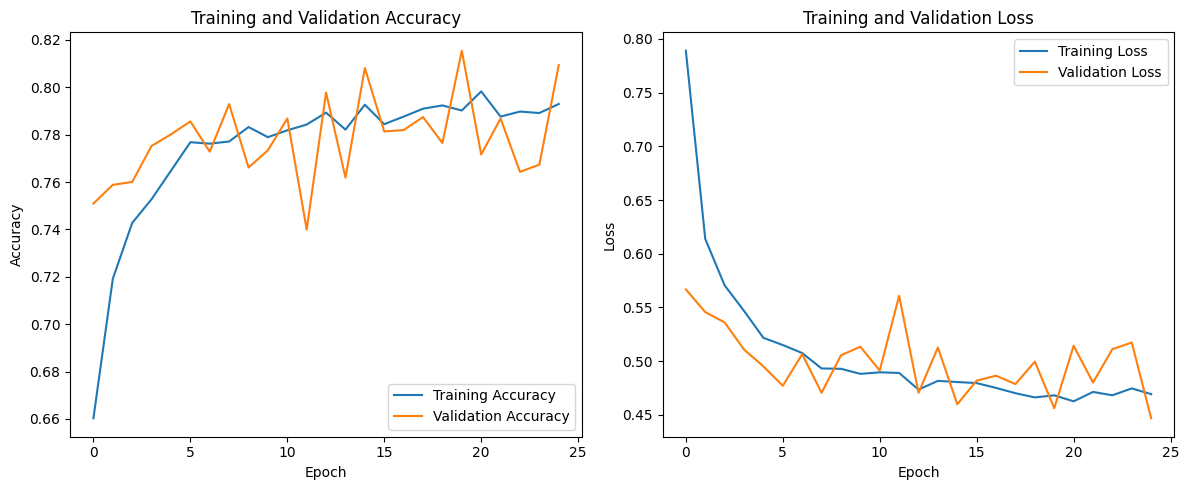

In [1]:
# train_model.py
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import os
import pathlib # Need pathlib for path operations

print("TensorFlow Version:", tf.__version__)

# --- Configuration Constants (Integrated) ---
# IMPORTANT: Update this path to your ACTUAL dataset directory
DATASET_PATH = pathlib.Path(r'C:\Users\91947\Desktop\dap and iot\test\result\pro') # <<<--- CHANGE THIS

MODEL_SAVE_PATH = pathlib.Path('./models') # Directory to save trained models
PLOTS_SAVE_PATH = pathlib.Path('./plots') # Directory to save training plots
MODEL_FILENAME = 'best_osteoporosis_resnet50.keras' # Saved model file name

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)
IMG_SHAPE = IMG_SIZE + (3,)
BATCH_SIZE = 32
BUFFER_SIZE = 1000 # For shuffling and prefetching

EPOCHS = 25 # Adjust as needed
VALIDATION_SPLIT = 0.2 # 20% for validation (used during training)

# Ensure these EXACTLY match your folder names
CLASS_NAMES = ['Normal', 'Osteopenia', 'Osteoporosis']
NUM_CLASSES = len(CLASS_NAMES)

# --- Create output directories if they don't exist ---
MODEL_SAVE_PATH.mkdir(parents=True, exist_ok=True)
PLOTS_SAVE_PATH.mkdir(parents=True, exist_ok=True)

# --- Validate Dataset Path ---
def check_dataset_path():
    if not DATASET_PATH.exists():
        print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        print(f"ERROR: Dataset path does not exist: {DATASET_PATH}")
        print(f"Please update DATASET_PATH at the top of this script.")
        print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        return False
    print(f"Using dataset path: {DATASET_PATH}")

    all_dirs_exist = True
    for class_name in CLASS_NAMES:
        class_dir = DATASET_PATH / class_name
        if not class_dir.is_dir():
            print(f"ERROR: Class directory not found: {class_dir}")
            all_dirs_exist = False

    if not all_dirs_exist:
         print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
         print(f"Please ensure subfolders matching CLASS_NAMES exist in {DATASET_PATH}")
         print(f"Expected: {CLASS_NAMES}")
         print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
         return False
    return True

if not check_dataset_path():
    exit("Exiting due to invalid dataset path.") # Stop execution if path is wrong

# --- 1. Load Data (Training and Validation only for this script) ---
print("\n--- Loading Training and Validation Data ---")

try:
    train_ds = image_dataset_from_directory(
        DATASET_PATH,
        labels='inferred',
        label_mode='categorical',
        class_names=CLASS_NAMES,
        image_size=IMG_SIZE,
        interpolation='nearest',
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=42,
        validation_split=VALIDATION_SPLIT,
        subset='training'
    )

    val_ds = image_dataset_from_directory(
        DATASET_PATH,
        labels='inferred',
        label_mode='categorical',
        class_names=CLASS_NAMES,
        image_size=IMG_SIZE,
        interpolation='nearest',
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=42,
        validation_split=VALIDATION_SPLIT,
        subset='validation'
    )
except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Check if DATASET_PATH is correct and contains the expected class folders.")
    exit()

print("Class names found:", train_ds.class_names)
if train_ds.class_names != CLASS_NAMES:
    print("Warning: Mismatch between defined CLASS_NAMES and loaded class names!")
    # Consider exiting or updating CLASS_NAMES dynamically if critical

# --- 2. Preprocessing ---
def preprocess_resnet(image, label):
    image = preprocess_input(image)
    return image, label

print("\n--- Applying Preprocessing ---")
train_ds = train_ds.map(preprocess_resnet, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess_resnet, num_parallel_calls=tf.data.AUTOTUNE)

# --- 3. Optimize Datasets ---
print("\n--- Optimizing Datasets (Caching & Prefetching) ---")
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# --- 4. Build ResNet50 Model ---
print("\n--- Building ResNet50 Model ---")

base_model = ResNet50(input_shape=IMG_SHAPE,
                      include_top=False,
                      weights='imagenet')
base_model.trainable = False

inputs = keras.Input(shape=IMG_SHAPE)
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs, outputs)

# --- 5. Compile Model ---
print("\n--- Compiling Model ---")
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

# --- 6. Define Callbacks ---
print("\n--- Setting up Callbacks ---")
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint_path = MODEL_SAVE_PATH / MODEL_FILENAME
model_checkpoint = ModelCheckpoint(filepath=str(model_checkpoint_path),
                                   save_best_only=True,
                                   monitor='val_accuracy',
                                   mode='max',
                                   verbose=1)

# --- 7. Train the Model ---
print("\n--- Starting Model Training ---")
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[early_stopping, model_checkpoint]
)
print("--- Training Finished ---")

# --- 8. Visualize Training Status and Save Plots ---
print("\n--- Visualizing and Saving Training History ---")
try:
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.tight_layout()
    plot_filename = PLOTS_SAVE_PATH / 'training_history.png'
    plt.savefig(str(plot_filename))
    print(f"Training history plot saved to: {plot_filename}")
    # plt.show()
except KeyError as e:
    print(f"Warning: Could not plot history. Missing key: {e}")
except Exception as e:
     print(f"An error occurred during plotting: {e}")


print(f"\nBest model saved to: {model_checkpoint_path}")
print("\n--- Training Script Complete ---")